<div id="singlestore-header" style="display: flex; background-color: rgba(209, 153, 255, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/notes.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">SingleStore Realtime PLG DB</h1>
    </div>
</div>

## Step 1 - Set up the Database in your Workspace

In [ ]:
%%sql
CREATE DATABASE IF NOT EXISTS S2SEGMENT;

## Make sure you now choose the S2SEGMENT Database from dropdown before running the next few cells.

In [45]:
%%sql
-- Create a table to store raw JSON from Segment

CREATE TABLE segment_raw_data (
  message JSON COLLATE utf8_bin,
  timestamp AS JSON_EXTRACT(message, '$.timestamp') PERSISTED datetime,
  event AS JSON_EXTRACT(message, '$.event') PERSISTED varchar(255) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
  messageId AS JSON_EXTRACT(message, '$.messageId') PERSISTED varchar(255) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
  type AS JSON_EXTRACT(message, '$.type') PERSISTED varchar(255) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
  user_id AS JSON_EXTRACT(message, '$.userId') PERSISTED varchar(255) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
  anonymous_id AS JSON_EXTRACT(message, '$.anonymousId') PERSISTED varchar(255) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci,
  SORT KEY () -- Empty sort key for unsorted order
  , SHARD KEY () -- Empty shard key for random distribution
)

++
||
++
++

In [46]:
%%sql

-- Account Table
CREATE TABLE Account (
    AccountID INT PRIMARY KEY,
    Name VARCHAR(255),
    Address VARCHAR(255),
    Type VARCHAR(255) CHECK (Type IN ('customer', 'previous customer or prospect'))
);

-- Opportunity Table
CREATE TABLE Opportunity (
    OpportunityID INT PRIMARY KEY,
    Name VARCHAR(255),
    Stage INT CHECK (Stage IN (1, 2, 3, 4, 5, 6)),
    StartDate DATE,
    CloseDate DATE,
    Status VARCHAR(255) CHECK (Status IN ('Open', 'Closed Won', 'Closed lost')),
    OpportunityValue FLOAT,
    AccountID INT
    
);

-- Trials Table
CREATE TABLE Trials (
    TrialID INT PRIMARY KEY,
    PeopleID INT, 
    StartDate DATETIME,
    EndDate DATETIME,
    Status VARCHAR(255) CHECK (Status IN ('Active', 'Dormant', 'Lost')),
    CreatedWorkspaceAt DATETIME,
    LoadedDataAt DATETIME,
    Notebook_hours INT,
    ConvertedToPaidAt DATETIME,
    OrgQueriesCount INT,
    Intercom_convo_count INT,
    Onboarding_steps_count INT,
    CampaignID INT,
    ProductID INT 
);

-- People Table
CREATE TABLE People (
    PeopleID INT PRIMARY KEY,
    Name VARCHAR(255),
    Title VARCHAR(255),
    PrimaryEmail VARCHAR(255),
    SecondaryEmail VARCHAR(255),
    PrimaryPhone VARCHAR(255),
    SecondaryPhone VARCHAR(255),
    AccountID INT,
    Type VARCHAR(255) CHECK (Type IN ('Contact', 'Lead', 'User'))

);

-- Product SKUs Table
CREATE TABLE Product_SKUs (
    ProductID INT PRIMARY KEY,
    Name VARCHAR(255),
    SKU VARCHAR(255),
    Status VARCHAR(255) CHECK (Status IN ('Current', 'Deprecated')),
    Price FLOAT
);

-- Campaigns Table
CREATE TABLE Campaigns (
    CampaignID INT PRIMARY KEY,
    PeopleID INT, -- Assuming there's a People table
    StartDate DATETIME,
    EndDate DATETIME,
    Cost FLOAT,
    CampaignType VARCHAR(255) CHECK (CampaignType IN ('Event', 'Online', 'Email')),
    Channel VARCHAR(255)
   
);



++
||
++
++

## Step 2 - Create a Zapier Webhook
Go to your Zapier account and create a Zap with a Webhook. Copy the Webhook URL

## Step 3 - Create a Segment destination
In your Segment account, create a destination and add the webhook URL. Create a rule if you want to choose what events you want to forward.

In [255]:
%%sql
## Step 4 - Query the nessages and create dashboards

++
||
++
++

In [721]:
!pip install matplotlib pandas tabulate --quiet

In [722]:
import json
import pandas as pd

# --- Fetch JSON Data ---
query = %sql SELECT message FROM segment_raw_data

# 1. Extract Data 
data = []
for row in query:
    data.append(row[0])

# 2. Normalize Directly
flattened_df = pd.json_normalize(data)

# 3. Display the DataFrame as a Table (With adjustments for all columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(flattened_df.head().to_markdown(index=False, numalign='left', stralign='left'))

| message.event   | message.messageId                                                | message.projectId      | message.properties.property1   | message.properties.property2   | message.properties.property3   | message.timestamp        | message.type   | message.userId                       |
|:----------------|:-----------------------------------------------------------------|:-----------------------|:-------------------------------|:-------------------------------|:-------------------------------|:-------------------------|:---------------|:-------------------------------------|
| Logged In       | 9f16784576c650cffcc2d832c6fa028d72072ac3fcbc749ffc253c2e5de955d3 | nzbHP77g4jyrf9DjWrSDFP | 1                              | test                           | True                           | 2024-06-13T14:40:17.010Z | track          | 02e6842f-9c33-4fbe-a7d2-45620ee13730 |
| Logged In       | f07243eed6a499010a9c301e2d921756f0e8671281529a762638b983848d115a | nzbHP77g4jyrf9DjWrSDFP | 1     

message.timestamp
2024-06-12     11
2024-06-13    802
dtype: int64


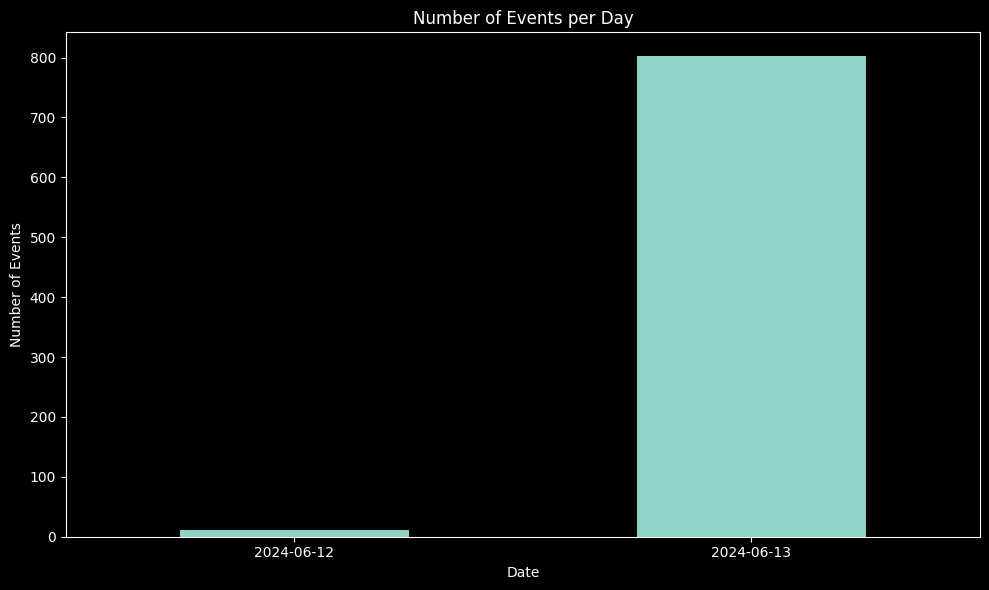

In [738]:
import matplotlib.pyplot as plt

# Number of events per day
flattened_df['message.timestamp'] = pd.to_datetime(flattened_df['message.timestamp'])
events_per_day = flattened_df.groupby(flattened_df['message.timestamp'].dt.date).size()
print(events_per_day)

# Create a bar plot for events per day
plt.figure(figsize=(10, 6))
events_per_day.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Number of Events per Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [743]:
# Users with the most events
users_with_most_events = flattened_df['message.userId'].value_counts().head()
print(users_with_most_events)

message.userId
02e6842f-9c33-4fbe-a7d2-45620ee13730    62
62a48aa0-91cf-431b-8e55-7e649dc6b3dd    20
228f1e46-d2c2-4e02-bfc3-ba3e69092b84    15
5e1362a8-7e61-44c3-b1ac-07a997774629    10
f9d58400-5928-40bd-87db-64d31b35e8f4     9
Name: count, dtype: int64


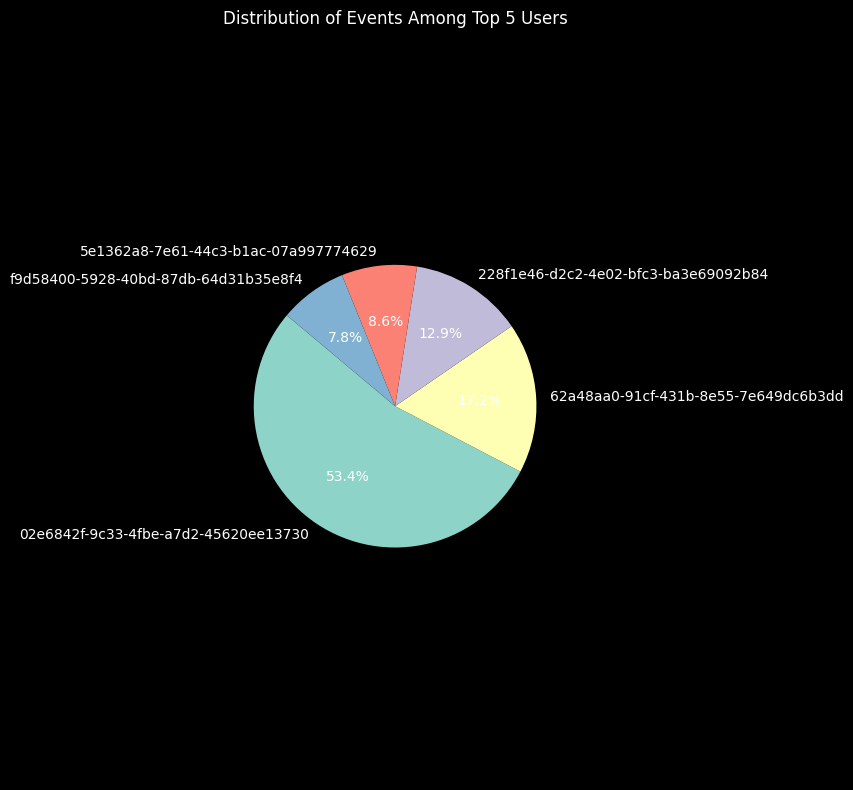

In [748]:
# Create a pie chart for users with most events
plt.figure(figsize=(8, 8))
plt.pie(users_with_most_events, labels=users_with_most_events.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Events Among Top 5 Users')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()